2022-02-16 20:11:53.707511: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


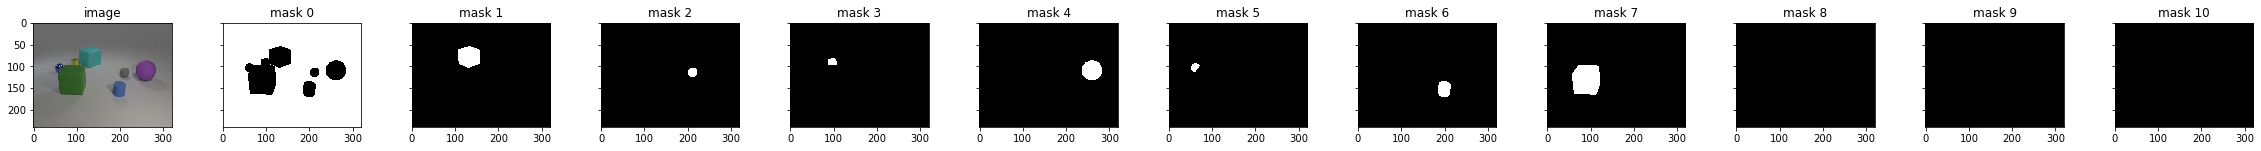

,visibility,x,y,z,pixel_coords,rotation,size,material,shape,color
0,True,0.000000,0.000000,0.00,"(tf.Tensor(0.0, shape=(), dtype=float32), tf.T...",0.000000,0,0,0,0
1,True,-2.365707,0.625255,0.70,"(tf.Tensor(131.0, shape=(), dtype=float32), tf...",171.261490,1,1,3,2
2,True,1.269057,1.046907,0.35,"(tf.Tensor(211.0, shape=(), dtype=float32), tf...",107.751411,2,1,1,6
3,True,-2.606125,-0.709509,0.35,"(tf.Tensor(98.0, shape=(), dtype=float32), tf....",229.034058,2,2,2,8
4,True,2.504530,1.830275,0.70,"(tf.Tensor(260.0, shape=(), dtype=float32), tf...",177.685455,1,1,1,7
5,True,-2.638200,-2.151204,0.35,"(tf.Tensor(61.0, shape=(), dtype=float32), tf....",260.119873,2,2,1,4
6,True,2.618906,-0.962137,0.35,"(tf.Tensor(199.0, shape=(), dtype=float32), tf...",320.096649,2,1,2,4
7,True,0.346145,-2.732890,0.70,"(tf.Tensor(92.0, shape=(), dtype=float32), tf....",22.800489,1,1,3,3
8,False,0.000000,0.000000,0.00,"(tf.Tensor(0.0, shape=(), dtype=float32), tf.T...",0.000000,0,0,0,0
9,False,0.000000,0.000000,0.00,"(tf.Tensor(0.0, shape=(), dtype=float32), tf.T...",0.000000,0,0,0,0


In [1]:
from functools import partial
from itertools import product
from operator import itemgetter
from pathlib import Path
from typing import Tuple

import einops
import matplotlib.pyplot as plt
import multi_object_datasets.clevr_with_masks
import numpy as np
import PIL.Image as PilImage
import scipy.optimize
import skimage.filters
import skimage.morphology
import tensorflow as tf
import torch.nn.functional
import tqdm
from einops import rearrange, reduce
from IPython.display import JSON, Image, Markdown, display, display_html
from matplotlib.ticker import PercentFormatter
from omegaconf import OmegaConf
from osc.data.clevr_with_masks import IMAGE_SIZE, fix_tf_dtypes, show_sample
from osc.data.utils import normalize_tf, unnormalize_pt
from osc.models.embeds import PositionalEmbedding
from osc.models.models import vit_slot_forward_with_attns
from osc.train import (
    build_dataset_train,
    build_dataset_val,
    build_losses,
    build_model,
    get_viz_batch,
)
from osc.utils import latest_checkpoint, print_arrays
from osc.viz.attentions import viz_slot_attns, viz_vit_attns
from osc.viz.backbone import kmeans_backbone
from osc.viz.embeds import viz_positional_embedding
from osc.viz.loss_global import viz_contrastive_loss_global
from osc.viz.loss_objects import (
    viz_contrastive_loss_objects,
    viz_contrastive_loss_objects_probs,
)
from osc.viz.rollout import self_attn_rollout, slot_attn_rollout
from osc.viz.utils import (
    array_to_pil,
    batched_otsu,
    batched_otsu_pt,
    fig_save_display,
    img_html,
    subplots_grid,
    text_html,
)
from osc.wandb_utils import find_run_by_name
from tabulate import tabulate
from torchvision.transforms.functional import to_pil_image

tfr_path = Path.home() / "multi-object-datasets/clevr_with_masks/imgs_test.tfrecords"
p = Path("06-Segmentation")

ds = tf.data.TFRecordDataset(tfr_path.as_posix(), compression_type="GZIP")
ds = ds.map(multi_object_datasets.clevr_with_masks._decode)
ds = ds.map(fix_tf_dtypes)
sample = ds.take(1).get_single_element()
show_sample(sample)

## Setup

Config

In [2]:
wandb_run_id = "angry-euler-65"
outputs_dir = Path("../outputs")
run_dir = outputs_dir / find_run_by_name(wandb_run_id, outputs_dir)
print(run_dir)

cfg = OmegaConf.load(run_dir / "train.yaml")
display(JSON(OmegaConf.to_container(cfg, resolve=True)))

cfg.other.device = "cuda:0"

num_patches = np.array(cfg.data.crop_size) // np.array(cfg.model.backbone.patch_size)

../outputs/2022-02-15/20-34-09


<IPython.core.display.JSON object>

Checkpoint

In [3]:
model = build_model(cfg)
checkpoint = torch.load(latest_checkpoint(run_dir), map_location="cpu")
model.load_state_dict(checkpoint["model"])
model.to(cfg.other.device)
model.train()
# model.eval()
del checkpoint

Test batch

[ True  True  True  True  True  True  True  True False False False]


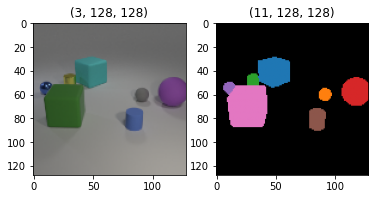

In [4]:
def mask_to_rgb(mask):
    # mask [C H W]
    if mask.dtype == torch.bool:
        mask = mask.float()
    mask = mask.argmax(dim=-3)
    colors = np.concatenate(
        [np.array([[0, 0, 0]]), np.array(plt.get_cmap("tab10").colors)], axis=0
    )
    return colors[mask]


@tf.function
def foo(
    example,
    img_size: Tuple[int, int],
    crop_size: Tuple[int, int],
    mean: Tuple[float, float, float],
    std: Tuple[float, float, float],
):
    # image: [H W 3]
    # mask: [C H W]
    image = example["image"]
    mask = example["mask"]

    H, W = img_size
    S = min(H, W)
    y0 = (H - S) // 2
    x0 = (W - S) // 2
    y1 = (H + S) // 2
    x1 = (W + S) // 2

    image = image[y0:y1, x0:x1, :]
    mask = mask[:, y0:y1, x0:x1]

    image = tf.image.convert_image_dtype(image, tf.float32)
    image = normalize_tf(image, mean, std)
    image = tf.image.resize(image, crop_size)
    image = tf.transpose(image, [2, 0, 1])

    mask = tf.cast(mask, tf.uint8)
    mask = tf.transpose(mask, [1, 2, 0])
    mask = tf.image.resize(mask, crop_size)
    mask = tf.transpose(mask, [2, 0, 1])
    mask = tf.cast(mask, tf.bool)

    # image: [3 H W]
    # mask: [C H W]
    return {"image": image, "mask": mask, "visibility": example["visibility"]}


example = next(
    ds.map(
        lambda example: foo(
            example,
            img_size=IMAGE_SIZE,
            crop_size=tuple(cfg.data.crop_size),
            mean=tuple(cfg.data.normalize.mean),
            std=tuple(cfg.data.normalize.std),
        )
    )
    .take(1)
    .as_numpy_iterator()
)
image = torch.from_numpy(np.copy(example["image"]))
mask = torch.from_numpy(np.copy(example["mask"]))
print(example["visibility"])

fig, axs = plt.subplot_mosaic("AB")
axs["A"].imshow(
    to_pil_image(
        unnormalize_pt(
            image,
            mean=tuple(cfg.data.normalize.mean),
            std=tuple(cfg.data.normalize.std),
        )
    )
)
axs["A"].set_title(str(tuple(image.shape)))
axs["B"].imshow(mask_to_rgb(mask))
axs["B"].set_title(str(tuple(mask.shape)))
del example, image, mask

## Examples
Forward pass test batch

In [5]:
B = 8
examples = (
    ds.map(
        lambda example: foo(
            example,
            img_size=IMAGE_SIZE,
            crop_size=tuple(cfg.data.crop_size),
            mean=tuple(cfg.data.normalize.mean),
            std=tuple(cfg.data.normalize.std),
        )
    )
    .batch(B)
    .take(1)
    .get_single_element()
)

images = torch.from_numpy(examples["image"].numpy()).to(cfg.other.device)
masks = torch.from_numpy(examples["mask"].numpy()).to(cfg.other.device)
visibility = examples["visibility"].numpy()

print_arrays(["images", "masks", "visibility"])

with torch.no_grad():
    with vit_slot_forward_with_attns(model) as f:
        _, vit_attns, slot_attns = f(images)

# Normalize images
images = unnormalize_pt(
    images,
    mean=tuple(cfg.data.normalize.mean),
    std=tuple(cfg.data.normalize.std),
)

print_arrays(vit_attns)
print_arrays(slot_attns)

name        dtype          shape
----------  -------------  -----------------
images      torch.float32  [8, 3, 128, 128]
masks       torch.bool     [8, 11, 128, 128]
visibility  bool           [8, 11]
name                    dtype          shape
----------------------  -------------  ------------------
backbone.attn_blocks.0  torch.float32  [8, 8, 1024, 1024]
backbone.attn_blocks.1  torch.float32  [8, 8, 1024, 1024]
backbone.attn_blocks.2  torch.float32  [8, 8, 1024, 1024]
backbone.attn_blocks.3  torch.float32  [8, 8, 1024, 1024]
name      dtype          shape
--------  -------------  -------------
obj_fn.0  torch.float32  [8, 11, 1024]
obj_fn.1  torch.float32  [8, 11, 1024]


Rollouts

In [6]:
def rollout_by_slot(slot_attns):
    slot_attns = [slot_attns[k] for k in sorted(slot_attns.keys())]
    roll = torch.clone(slot_attns[0])
    for attn in slot_attns[1:]:
        roll.add_(attn)
    return roll.div_(len(slot_attns))


def rollout_sum_1(slot_attns):
    slot_attns = [
        slot_attns[k] / slot_attns[k].sum(dim=-1, keepdim=True)
        for k in sorted(slot_attns.keys())
    ]
    roll = torch.clone(slot_attns[0])
    for attn in slot_attns[1:]:
        roll.add_(attn)
    return roll.div_(len(slot_attns))


def rollout_first_iter(slot_attns):
    return slot_attns[sorted(slot_attns.keys())[0]]


def reshape_attn(attn):
    return rearrange(
        attn, "B S (K_h K_w) -> B S K_h K_w", K_h=num_patches[0], K_w=num_patches[1]
    )


def upsample_attn(attn):
    B, S, H, W = attn.shape
    return torch.nn.functional.interpolate(
        attn, tuple(cfg.data.crop_size), mode="nearest"
    )
    # return torch.nn.functional.interpolate(attn, tuple(cfg.data.crop_size), mode='bilinear', align_corners=False)


def masks_argmax(masks):
    *B, S, H, W = masks.shape
    masks = masks.argmax(dim=-3, keepdim=True)
    arange = torch.arange(S, device=masks.device)[:, None, None]
    return masks == arange


# Compute rollouts
vit_rollout = self_attn_rollout(vit_attns, adjust_residual=False, global_avg_pool=False)

slot_rollouts_dict = {}
for rollout_fn, to_mask_fn in product(
    [rollout_first_iter, rollout_by_slot, rollout_sum_1],
    [masks_argmax, batched_otsu_pt],
):
    a = rollout_fn(slot_attns)
    a = reshape_attn(a)
    a = upsample_attn(a)
    m = to_mask_fn(a)
    slot_rollouts_dict[(rollout_fn.__name__, to_mask_fn.__name__)] = (a, m)

# slot_rollout_full = torch.bmm(slot_rollout / slot_rollout.sum(-1,keepdim=True), vit_rollout)

print_arrays({k: v[0] for k, v in slot_rollouts_dict.items()})
print_arrays({k: v[1] for k, v in slot_rollouts_dict.items()})

name                                       dtype          shape
-----------------------------------------  -------------  -----------------
('rollout_first_iter', 'masks_argmax')     torch.float32  [8, 11, 128, 128]
('rollout_first_iter', 'batched_otsu_pt')  torch.float32  [8, 11, 128, 128]
('rollout_by_slot', 'masks_argmax')        torch.float32  [8, 11, 128, 128]
('rollout_by_slot', 'batched_otsu_pt')     torch.float32  [8, 11, 128, 128]
('rollout_sum_1', 'masks_argmax')          torch.float32  [8, 11, 128, 128]
('rollout_sum_1', 'batched_otsu_pt')       torch.float32  [8, 11, 128, 128]
name                                       dtype       shape
-----------------------------------------  ----------  -----------------
('rollout_first_iter', 'masks_argmax')     torch.bool  [8, 11, 128, 128]
('rollout_first_iter', 'batched_otsu_pt')  torch.bool  [8, 11, 128, 128]
('rollout_by_slot', 'masks_argmax')        torch.bool  [8, 11, 128, 128]
('rollout_by_slot', 'batched_otsu_pt')     torch.bo

In [7]:
S = cfg.model.obj_queries.num_objects

for b in range(B):
    fig, axs = subplots_grid(
        2 + len(slot_rollouts_dict) * 2, S, ax_height_inch=2, dpi=100
    )

    ax = axs[0, 0]
    ax.imshow(to_pil_image(images[b]))

    ax = axs[0, 1]
    ax.imshow(mask_to_rgb(masks[b].cpu()), interpolation="none")

    axs[1, 0].set_ylabel("GT masks")
    for t in range(S):
        ax = axs[1, t]
        ax.imshow(masks[b, t].cpu(), interpolation="none")

    for k, axs_row in zip(
        slot_rollouts_dict.keys(), axs[2:].reshape(len(slot_rollouts_dict), 2, -1)
    ):
        axs_row[0, 0].set_ylabel(k[0] + "\n")
        axs_row[1, 0].set_ylabel("\n".join(k))
        for s in range(S):
            ax = axs_row[0, s]
            ax.imshow(slot_rollouts_dict[k][0][b, s].cpu(), interpolation="none")
            ax = axs_row[1, s]
            ax.imshow(slot_rollouts_dict[k][1][b, s].cpu(), interpolation="none")

    for ax in axs.flat:
        ax.set_xticks([])
        ax.set_yticks([])

    fig.set_facecolor("white")
    fig.tight_layout(pad=0, h_pad=0, w_pad=0)
    fig.savefig(p / f"slot_rollout_options.{b}.png")
    plt.close(fig)
    display(Image(url=p / f"slot_rollout_options.{b}.png", width=1200))

In [8]:
def match_masks(masks, preds, preds_thres):
    """Match predicted and ground-truth segmentation masks.

    Args:
        masks: binary ground-truth masks ``[B T H W]``
        preds: float prediction masks ``[B S H W]`` for DICE matching
        preds_thres: binarized prediction masks ``[B S H W]`` for IoU matching

    Returns:
        Tuple of ``(iou_idx, iou_val, dice_idx, dice_val)``.
        IoU indexes indicate that the best match for ``masks[b, t]`` is
        ``preds_thres[b, iou_idx[b, t]]`` with an IoU of ``iou_val[b, t]`.
        DICE indexes indicate that the best match for ``masks[b, t]`` is
        ``preds[b, dice_idx[b, t]]`` with a DICE score of ``dice_val[b, t]`.
    """
    assert masks.dtype == torch.bool
    device = masks.device
    masks = rearrange(masks, "B T H W -> B T 1 (H W)")
    preds = rearrange(preds, "B S H W -> B 1 S (H W)")
    preds_thres = rearrange(preds_thres, "B S H W -> B 1 S (H W)")

    # iou [B T S]
    intersection = torch.logical_and(masks, preds_thres).float().sum(-1)
    union = torch.logical_or(masks, preds_thres).float().sum(-1)
    iou = intersection.div_(union.clamp_min_(1e-8))
    iou = iou.cpu().numpy()

    # iou_idx, iou_val: [B T]
    iou_idx = []
    iou_val = []
    for b in range(iou.shape[0]):
        rows, cols = scipy.optimize.linear_sum_assignment(iou[b], maximize=True)
        iou_val.append(iou[b, rows, cols])
        iou_idx.append(cols[np.argsort(rows)])
    iou_idx = torch.from_numpy(np.stack(iou_idx, axis=0)).to(device)
    iou_val = torch.from_numpy(np.stack(iou_val, axis=0)).to(device)

    # dice: [B T S]
    masks = masks.float()
    intersection = torch.sum(masks * preds, dim=-1)
    union = torch.sum(masks, dim=-1) + torch.sum(preds, dim=-1)
    dice = intersection.mul_(2).div_(union.clamp_min_(1e-8))
    dice = dice.cpu().numpy()

    # dice_idx, dice_val: [B T]
    dice_idx = []
    dice_val = []
    for b in range(masks.shape[0]):
        rows, cols = scipy.optimize.linear_sum_assignment(dice[b], maximize=True)
        dice_val.append(dice[b, rows, cols])
        dice_idx.append(cols[np.argsort(rows)])
    dice_idx = torch.from_numpy(np.stack(dice_idx, axis=0)).to(device)
    dice_val = torch.from_numpy(np.stack(dice_val, axis=0)).to(device)

    return iou_idx, iou_val, dice_idx, dice_val


slot_rollout, slot_rollout_thres = slot_rollouts_dict[
    ("rollout_first_iter", "batched_otsu_pt")
]
iou_idx, iou_val, dice_idx, dice_val = match_masks(
    masks, slot_rollout, slot_rollout_thres
)

print(
    tabulate(
        list(
            zip(
                range(B),
                100
                * np.mean(
                    iou_val[:, 1:].cpu().numpy(), where=visibility[:, 1:], axis=1
                ),
                100
                * np.mean(
                    dice_val[:, 1:].cpu().numpy(), where=visibility[:, 1:], axis=1
                ),
            )
        ),
        headers=["b", "IoU %", "DICE %"],
        floatfmt=".1f",
    )
)

  b    IoU %    DICE %
---  -------  --------
  0     57.9      45.5
  1     30.9      29.1
  2     36.7      29.3
  3     35.5      28.3
  4     23.3      22.2
  5     26.9      27.9
  6     50.9      41.9
  7     22.5      23.1


In [9]:
S = cfg.model.obj_queries.num_objects

for b in range(B):

    print("Image", b)

    for name, idx, val in [("IoU", iou_idx, iou_val), ("DICE", dice_idx, dice_val)]:
        val_total = np.mean(val[b, 1:].cpu().numpy(), where=visibility[b, 1:])
        print(f"{name} total {val_total:.1%}")

        fig, axs = subplots_grid(5, S, ax_height_inch=2, dpi=70)

        ax = axs[0, 0]
        ax.imshow(to_pil_image(images[b]))
        ax.set_title(f"Image {b}")

        ax = axs[0, 1]
        ax.imshow(vit_rollout[b].cpu(), interpolation="none")

        for ax in axs[0, 2:]:
            ax.set_axis_off()

        for t in range(S):
            s = idx[b, t]

            ax = axs[1, t]
            ax.imshow(slot_rollout[b, s].cpu(), interpolation="none")

            ax = axs[2, t]
            ax.imshow(slot_rollout_thres[b, s].cpu(), interpolation="none")

            ax = axs[3, t]
            ax.imshow(
                to_pil_image(
                    torch.where(
                        slot_rollout_thres[b, s],
                        images[b],
                        0.3 * images[b],
                    )
                ),
                interpolation="none",
            )

            ax = axs[4, t]
            ax.imshow(masks[b, t].cpu(), interpolation="none")
            ax.set_xlabel(f"Mask {t} slot {s}\n{name} {val[b, t]:.2f}")

        axs[1, 0].set_ylabel("Attn")
        axs[2, 0].set_ylabel("Thresholded")
        axs[3, 0].set_ylabel("Overlay")
        axs[4, 0].set_ylabel(f"Ground-truth\n{name} total {val_total:.2f}")

        for ax in axs.flat:
            ax.set_xticks([])
            ax.set_yticks([])

        fig.set_facecolor("white")
        fig.tight_layout(pad=0, h_pad=0, w_pad=0)
        fig.savefig(p / f"img{b}.{name.lower()}.png")
        plt.close(fig)
        display(Image(url=p / f"img{b}.{name.lower()}.png"))

Image 0
IoU total 57.9%


DICE total 45.5%


Image 1
IoU total 30.9%


DICE total 29.1%


Image 2
IoU total 36.7%


DICE total 29.3%


Image 3
IoU total 35.5%


DICE total 28.3%


Image 4
IoU total 23.3%


DICE total 22.2%


Image 5
IoU total 26.9%


DICE total 27.9%


Image 6
IoU total 50.9%


DICE total 41.9%


Image 7
IoU total 22.5%


DICE total 23.1%


## Full dataset

In [10]:
B = 32

ious = []
dices = []

bar = tqdm.tqdm(unit=" imgs")
for examples in (
    ds.map(
        lambda example: foo(
            example,
            img_size=IMAGE_SIZE,
            crop_size=tuple(cfg.data.crop_size),
            mean=tuple(cfg.data.normalize.mean),
            std=tuple(cfg.data.normalize.std),
        )
    )
    # .take(5*B)
    .batch(B, drop_remainder=False).as_numpy_iterator()
):
    images = torch.from_numpy(np.copy(examples["image"])).to(cfg.other.device)
    masks = torch.from_numpy(np.copy(examples["mask"])).to(cfg.other.device)
    visibility = examples["visibility"]

    with torch.no_grad():
        with vit_slot_forward_with_attns(model) as f:
            _, _, slot_attns = f(images)

    slot_rollout = upsample_attn(reshape_attn(rollout_first_iter(slot_attns)))
    slot_rollout_thres = batched_otsu_pt(slot_rollout)
    _, iou_val, _, dice_val = match_masks(masks, slot_rollout, slot_rollout_thres)
    iou_val = iou_val.cpu().numpy()
    dice_val = dice_val.cpu().numpy()

    ious.extend(iou_val[b, visibility[b]] for b in range(images.shape[0]))
    dices.extend(dice_val[b, visibility[b]] for b in range(images.shape[0]))

    bar.update(images.shape[0])
bar.close()

15000 imgs [02:41, 93.15 imgs/s]


Metric    Average                     Value
--------  ------------------------  -------
IoU       mean all                    47.1%
IoU       mean no bg                  40.1%
IoU       mean (mean by img no bg)    43.2%
DICE      mean all                    42.2%
DICE      mean no bg                  34.6%
DICE      mean (mean by img no bg)    36.7%


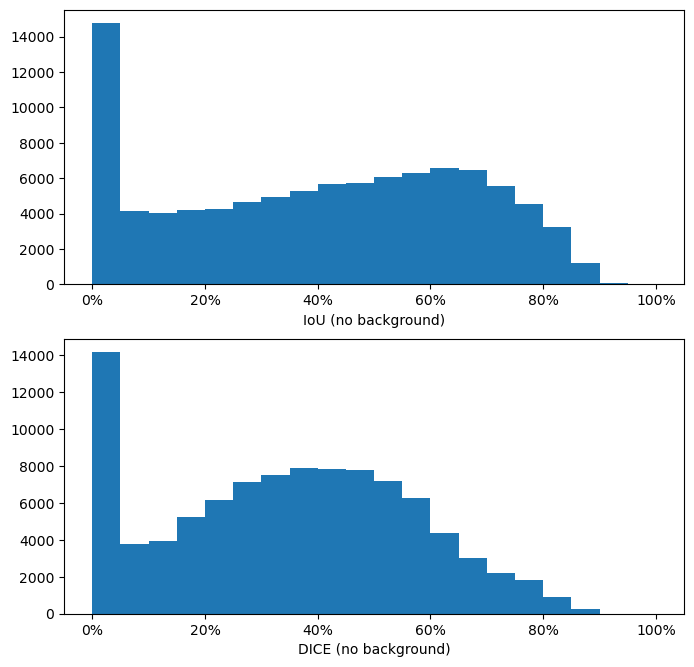

In [11]:
print(
    tabulate(
        [
            (
                "IoU",
                "mean all",
                np.mean([v for slot_ious in ious for v in slot_ious]),
            ),
            (
                "IoU",
                "mean no bg",
                np.mean([v for slot_ious in ious for v in slot_ious[1:]]),
            ),
            (
                "IoU",
                "mean (mean by img no bg)",
                np.mean([slot_ious[1:].mean() for slot_ious in ious]),
            ),
            (
                "DICE",
                "mean all",
                np.mean([v for slot_dices in dices for v in slot_dices]),
            ),
            (
                "DICE",
                "mean no bg",
                np.mean([v for slot_dices in dices for v in slot_dices[1:]]),
            ),
            (
                "DICE",
                "mean (mean by img no bg)",
                np.mean([slot_dices[1:].mean() for slot_dices in dices]),
            ),
        ],
        headers=["Metric", "Average", "Value"],
        floatfmt=".1%",
    )
)

fig, axs = plt.subplots(2, 1, figsize=(8, 8), dpi=100)

ax = axs[0]
ax.hist(
    [v for slot_ious in ious for v in slot_ious[1:]], bins=np.linspace(0, 1, num=21)
)
ax.xaxis.set_major_formatter(PercentFormatter(1.0))
ax.set_xlabel("IoU (no background)")

ax = axs[1]
ax.hist(
    [v for slot_dices in dices for v in slot_dices[1:]], bins=np.linspace(0, 1, num=21)
)
ax.xaxis.set_major_formatter(PercentFormatter(1.0))
ax.set_xlabel("DICE (no background)");